In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Funnynet

## A neural network that makes jokes

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

In [2]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math, random

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [4]:
files = list(PATH.iterdir())
print(files)

[PosixPath('data/val'), PosixPath('data/.ipynb_checkpoints'), PosixPath('data/nietzsche'), PosixPath('data/trn'), PosixPath('data/stupidstuff.json'), PosixPath('data/reddit_jokes.json')]


In [5]:
for fname in files:
    if "eddit" in str(fname):
        reddit_dataset = str(fname)
    if "upid" in str(fname):
        stupid_dataset = str(fname)
reddit_jokes = json.load(open(reddit_dataset))
stupid_jokes = json.load(open(stupid_dataset))

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [6]:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

In [7]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

Let's see how many jokes have really high scores:

In [8]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

'I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"'

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string, using the `EOJ` tag.

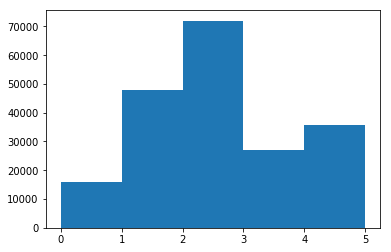

In [9]:
all_jokes = []
for i in range(len(reddit_jokes)):
    r_joke = reddit_jokes[i]
    #|print(r_joke)
    r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
    if r_joke['rating']>5:
        r_joke['rating']=5
    del r_joke['score'] 
    r_joke['body'] = r_joke['title']+" "+r_joke['body']
    del r_joke['title']
for s_joke in stupid_jokes:
    del s_joke['category']

combined = [joke['rating'] for joke in reddit_jokes]
combined = combined + [joke['rating'] for joke in stupid_jokes]
plt.hist(combined,bins=5);

combined_jokes = reddit_jokes + stupid_jokes

title_body = [joke['body']+' ' for joke in combined_jokes]

In [10]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 800000: 
        break

In [11]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 125


In [12]:
chars.insert(0, "\0")
print(chars)

['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '\u2028', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


In [13]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [14]:
idx = [char_indices[c] for c in text]

idx[:10]

[3, 44, 3, 75, 68, 87, 72, 3, 75, 82]

In [15]:
''.join(indices_char[i] for i in idx[:70])

' I hate how you cant even say black paint anymore Now I have to say "L'

 ## Three character model

In [16]:
n_hidden = 256
embeddings_sz = 42 # size of embeddings matrix

In [17]:
# These libraries require some setup, try the pip install git+https.github.com/... trick
from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

In [18]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

NameError: name 'x1' is not defined

In [ ]:
model = ThreeCharRNN(vocab_size, embeddings_sz).cuda()

### Let's create a bigger RNN!

In [ ]:
rnn_len=8

In [ ]:
# char_in_jokes = [[idx[i+j] for i in range(rnn_len)] for j in range(len(idx)-rnn_len)]

char_input = []
for j in range(len(idx)-rnn_len):
    tmp = []
    for i in range(rnn_len):
        tmp.append(idx[i+j])
    char_input.append(tmp)

In [ ]:
char_output = []
for j in range(len(idx)-rnn_len):
    char_output.append(idx[j+rnn_len])

In [ ]:
xs = np.stack(char_input, axis=0)

In [ ]:
xs.shape

In [ ]:
y = np.stack(char_output)
y.shape

In [ ]:
xs[:rnn_len,:rnn_len]

In [ ]:
len(y[:rnn_len])

In [ ]:
val_idx = get_cv_idxs(len(idx)-rnn_len-1)
# val_idx.shape
model_data = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [ ]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
#         pdb.set_trace()
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
            
        return F.log_softmax(self.l_out(h), dim=-1)

In [ ]:
model = CharLoopModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(model.parameters(), 1e-2)

In [ ]:
fit(model, model_data, epochs=1, opt=opt, crit=F.nll_loss)

In [ ]:
set_lrs(opt, 0.001)

In [ ]:
fit(model, model_data, epochs=1, opt=opt, crit=F.nll_loss)

In [ ]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = model(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [ ]:
get_next('for thos')

In [ ]:
get_next(' a blond')

In [ ]:
get_next('into a b')

In [ ]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
get_next_n('into a b', 40)

In [ ]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = torch.cat((h, self.e(c)), 1)
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [ ]:
m = CharLoopConcatModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [ ]:
fit(m, md, 1, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
fit(m, md, 1, opt, F.nll_loss)

In [ ]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [ ]:
get_next('wome')

In [ ]:
get_next('beca')

In [ ]:
get_next('char')

### Model with Multiple Outputs

In [ ]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        #print("rnn_len: "+str(rnn_len))
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [ ]:
m = CharRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [ ]:
t = m.e(V(torch.stack(xs)))
t.size()

In [ ]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

In [ ]:
t = m(*V(xs)); t.size()

In [ ]:
fit(m, md, 4, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
fit(m, md, 2, opt, F.nll_loss)

In [ ]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [ ]:
get_next('for thos')

In [ ]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
get_next_n('for thos', 40)

In [ ]:
c_in_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(0, len(idx)-rnn_len-1, rnn_len)]

In [ ]:
c_out_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(1, len(idx)-rnn_len, rnn_len)]

In [ ]:
xs = np.stack(c_in_dat)
xs.shape

In [ ]:
xs[:rnn_len,:rnn_len]

In [ ]:
ys = np.stack(c_out_dat)
ys.shape

In [ ]:
ys[:rnn_len,:rnn_len]

In [ ]:
val_idx = get_cv_idxs(len(xs)-rnn_len-1)

In [ ]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [ ]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)

In [ ]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
it = iter(md.trn_dl)
*xst,yt = next(it)
#t = m(*V(xs))

In [ ]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [ ]:
fit(m, md, 4, opt, nll_loss_seq)

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
fit(m, md, 1, opt, nll_loss_seq)

In [ ]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [ ]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))

In [ ]:
fit(m, md, 4, opt, nll_loss_seq)

In [ ]:
set_lrs(opt, 1e-3)

In [ ]:
fit(m, md, 4, opt, nll_loss_seq)

### Adding State: RNN

In [ ]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

In [ ]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

In [ ]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

In [ ]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [ ]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
fit(m, md, 4, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

### LSTM
Now we will try an LSTM

In [ ]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *
from fastai import sgdr
n_hidden = 256

In [ ]:
val_idx = get_cv_idxs(len(xs)-rnn_len-1)

In [ ]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [ ]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, embeddings_sz, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.LSTM(embeddings_sz, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, rnn_len):
        bs = rnn_len[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(rnn_len), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [ ]:
m = CharSeqStatefulLSTM(md.nt, embeddings_sz, 512, 2).cuda()
#lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [ ]:
#fit(m, md, 2, lo.opt, F.nll_loss)